In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy import stats
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from IPython.display import HTML

In [90]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [91]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [92]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

In [93]:
df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

In [94]:
df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

In [95]:
df = df.fillna(value = 0)

In [96]:
df.index = range(0, len(df))

In [97]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

In [98]:
spread_samples = np.random.choice(week5_df.spread_favorite,25)
sample_means = spread_samples.mean()

def n_samples(arr,sample_size,n_samples):
    size = sample_size
    sample_means=[]
    
    for n in range(n_samples):
        sample_means.append(np.random.choice(arr,size).mean())
    
    return sample_means

x = n_samples(week5_df.spread_favorite,25,1000)

#sns.distplot(x)

# ax1 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==1)],100,5000)
# ax2 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==0)],100,5000)
# sns.distplot(ax1)
# sns.distplot(ax2)
# sum(week5_df.spread_favorite<-12.5)/len(week5_df)
# np.sum(ax1)/len(ax1)
# np.sum(ax2)/len(ax2)

In [99]:
o_u_pivot = reg_df.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [100]:
o_u_pivot['row_total'] = 0
for index, row in o_u_pivot.iterrows():
    row.row_total = sum(row)

In [101]:
ou_covered = o_u_pivot.over_under_result['over']
ou_no_cover = o_u_pivot.over_under_result['under']
ou_push = o_u_pivot.over_under_result['push']

In [102]:
lines = sorted(set(reg_df.over_under_line))
x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [103]:
pivot = reg_df.pivot_table(index='spread_favorite', columns='favorite_covered',
                    aggfunc={'favorite_covered':len}, fill_value = 0)

In [104]:
y_over = [ou_covered[value]/o_u_pivot['row_total'][value] for value in x_lines]
y_under = [ou_no_cover[value]/o_u_pivot['row_total'][value] for value in x_lines]
y_neither = [ou_push[value]/o_u_pivot['row_total'][value] for value in x_lines]

In [105]:
pivot['row_total'] = 0
for index, row in pivot.iterrows():
    row.row_total = sum(row)

In [106]:
covered = pivot.favorite_covered[1]
no_cover = pivot.favorite_covered[0]
push = pivot.favorite_covered[2]

In [107]:
spreads = sorted(set(reg_df.spread_favorite))
x_spreads = np.array([spread for spread in spreads if spread > -15 and spread < 0])

In [108]:
y_covered = [covered[value]/pivot['row_total'][value] for value in x_spreads]
y_no_cover = [no_cover[value]/pivot['row_total'][value] for value in x_spreads]
y_push = [push[value]/pivot['row_total'][value] for value in x_spreads]

In [109]:
heat_o_u = reg_df[['over_under_line','weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']]
corr_o_u = heat_o_u.corr()
heat_spread = reg_df[['spread_favorite','exp_win_difference', 'home_favorite', 'total_points_against', 'total_ppg','weather_temperature']]
corr_spread = heat_spread.corr()

In [110]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
#     split = train_test_split(x, y)
#     X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
#     x = X_train
#     y = y_train
#     plt.scatter(x, y, s = s, alpha = alpha)
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [111]:
def regression_evaluation(target, X_list):
    target = target
    X = X_list 
    X2 = sm.add_constant(X)
    # model = sm.ols(formula = 'over_under_line ~ np.power(total_points_against, 1)', data = reg_df).fit()

    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [112]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [113]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [114]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [115]:
test_df = week5_df[week5_df.schedule_season>2010]


In [116]:
home_scores,away_scores = list(week5_df.score_home),list(week5_df.score_away)
all_scores = []
all_scores.extend(home_scores)
all_scores.extend(away_scores)

import collections
from operator import itemgetter


# Sample of Dataframe

In [117]:
reg_df.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,...,away_pt_diff_pg,pt_diff_pg,home_exp_win_pct,away_exp_win_pct,home_win_pct_last_4,away_win_pct_last_4,exp_win_difference,total_ppg,total_points_against,last_four_difference
5387,09/15/2002,2002,2,Atlanta Falcons,Chicago Bears,ATL,-2.5,45.0,DOME,72.0,...,4.0,-7.0,0.368063,0.719232,0.00,0.25,-0.351169,61.0,60.0,-0.25
5388,09/15/2002,2002,2,Baltimore Ravens,Tampa Bay Buccaneers,TB,-4.5,32.0,0,73.0,...,-6.0,3.0,0.180159,0.181480,0.00,0.00,-0.001321,27.0,36.0,0.00
5389,09/15/2002,2002,2,Carolina Panthers,Detroit Lions,CAR,-3.0,35.5,0,70.0,...,-28.0,31.0,0.819841,0.004504,0.25,0.00,0.815337,31.0,56.0,0.25
5390,09/15/2002,2002,2,Cleveland Browns,Cincinnati Bengals,CLE,-3.5,39.0,0,72.0,...,-28.0,27.0,0.458620,0.000068,0.00,0.00,0.458552,45.0,74.0,0.00
5391,09/15/2002,2002,2,Dallas Cowboys,Tennessee Titans,TEN,-3.5,37.5,0,79.0,...,3.0,-12.0,0.037651,0.666962,0.00,0.25,-0.629311,37.0,43.0,-0.25


# Distributions

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



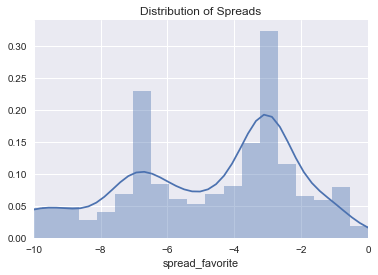

In [118]:
rw5 = np.random.choice(week5_df.spread_favorite,10)

ax = sns.distplot(week5_df.spread_favorite)
ax.set_xlim(-10,0)
ax.set_title('Distribution of Spreads');

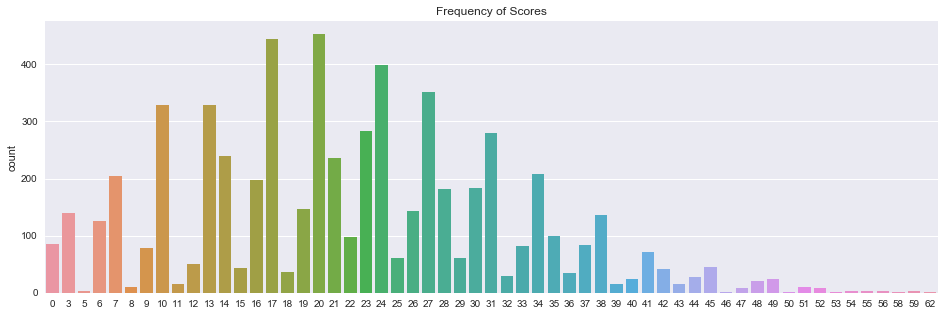

In [119]:
score_freq = collections.Counter(all_scores)

plt.figure(figsize=(16,5))
sns.countplot(all_scores)
plt.title('Frequency of Scores');

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



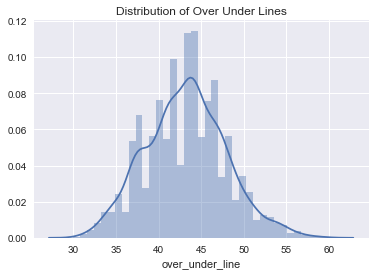

In [120]:
sns.distplot(reg_df.over_under_line)
plt.title('Distribution of Over Under Lines');

# Spread Summaries

In [121]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=x_lines,
    y=y_over,
    name='Over'
)
trace2 = go.Bar(
    x=x_lines,
    y=y_under,
    name='Under'
)

trace3 = go.Bar(
    x=x_lines,
    y=y_neither,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',title='Outcomes for each Over Under Line'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [122]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=x_spreads,
    y=y_covered,
    name='Covered'
)
trace2 = go.Bar(
    x=x_spreads,
    y=y_no_cover,
    name='No Cover'
)

trace3 = go.Bar(
    x=x_spreads,
    y=y_push,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',title='Outcomes for each Spread Line'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

# Correlation Heatmaps

,over_under_line,weather_wind_mph,weather_humidity,total_points_against,total_ppg,weather_temperature
over_under_line,1.000000,-0.278144,-0.072963,0.358626,0.601954,0.161149
weather_wind_mph,-0.278144,1.000000,0.007393,-0.092258,-0.081021,-0.369755
weather_humidity,-0.072963,0.007393,1.000000,-0.017911,-0.041513,-0.059259
total_points_against,0.358626,-0.092258,-0.017911,1.000000,-0.036109,0.043556
total_ppg,0.601954,-0.081021,-0.041513,-0.036109,1.000000,-0.025085
weather_temperature,0.161149,-0.369755,-0.059259,0.043556,-0.025085,1.000000


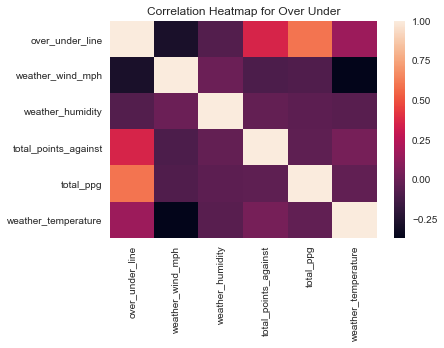

In [123]:
sns.heatmap(corr_o_u,xticklabels=corr_o_u.columns,
        yticklabels=corr_o_u.columns)
plt.title('Correlation Heatmap for Over Under')
display(corr_o_u)

,spread_favorite,exp_win_difference,home_favorite,total_points_against,total_ppg,weather_temperature
spread_favorite,1.000000,-0.368167,-0.195108,-0.031186,0.030883,0.072987
exp_win_difference,-0.368167,1.000000,0.524128,-0.001068,-0.007244,-0.075372
home_favorite,-0.195108,0.524128,1.000000,-0.035127,-0.034868,-0.043117
total_points_against,-0.031186,-0.001068,-0.035127,1.000000,-0.036109,0.043556
total_ppg,0.030883,-0.007244,-0.034868,-0.036109,1.000000,-0.025085
weather_temperature,0.072987,-0.075372,-0.043117,0.043556,-0.025085,1.000000


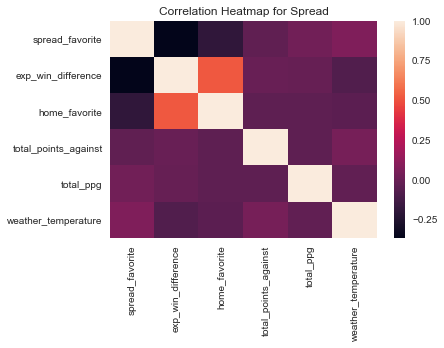

In [124]:
sns.heatmap(corr_spread,xticklabels=corr_spread.columns,
        yticklabels=corr_spread.columns)
plt.title('Correlation Heatmap for Spread')
display(corr_spread)

# LINEAR REGRESSIONS

# OVER/UNDER

# Variable 1 -Total Points Against

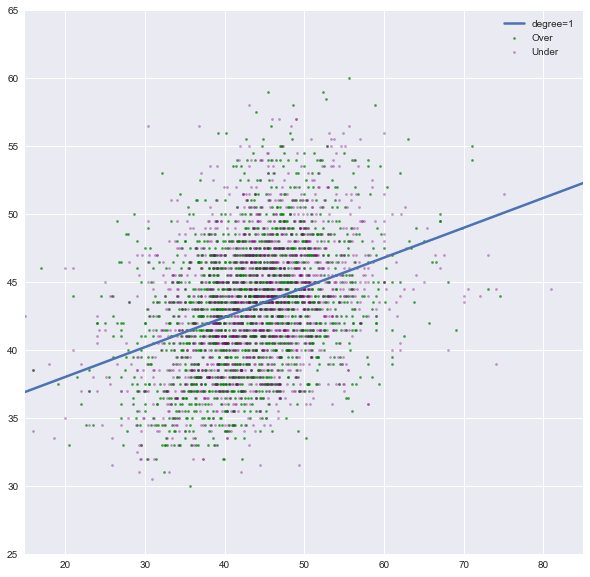

In [125]:
poly_regression((reg_df.total_points_against), reg_df.over_under_line, [1],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     566.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          6.17e-117
Time:                        17:38:46   Log-Likelihood:                -11140.
No. Observations:                3841   AIC:                         2.228e+04
Df Residuals:                    3839   BIC:                         2.230e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   33.6210 

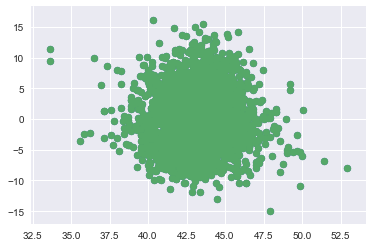

In [126]:
regression_evaluation(reg_df.over_under_line, reg_df.total_points_against)

# VARIABLE 2 -TOTAL PPG

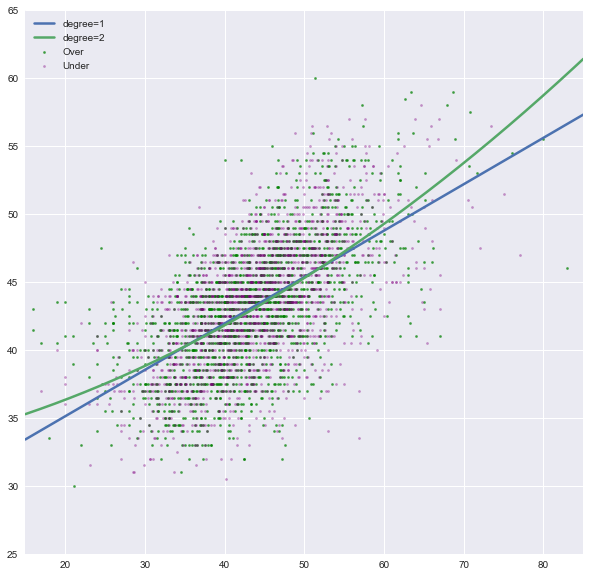

In [127]:
poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2182.
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:38:47   Log-Likelihood:                -10540.
No. Observations:                3841   AIC:                         2.108e+04
Df Residuals:                    3839   BIC:                         2.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2891      0.325     87.052      0.0

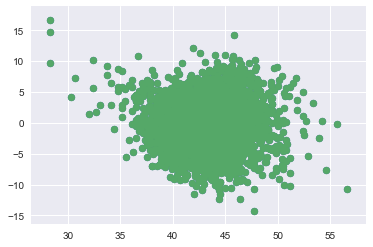

In [128]:
regression_evaluation(reg_df.over_under_line, (reg_df.total_ppg**1))

# ALL VARIABLES FOR OVER/UNDER

#### Variables: Total PPG, Total PaPG, Wind mph, Humidity, Temperature

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     957.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:38:47   Log-Likelihood:                -9848.5
No. Observations:                3841   AIC:                         1.971e+04
Df Residuals:                    3835   BIC:                         1.975e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5255      0.570     32.486      0.0

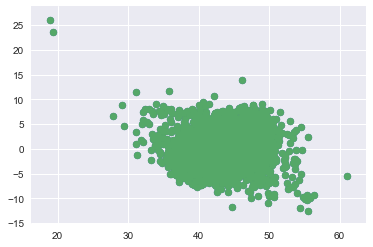

In [129]:
regression_evaluation(reg_df.over_under_line, reg_df[['weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)

# SPREAD 

## SECOND VARIABLE - Exp Win Difference

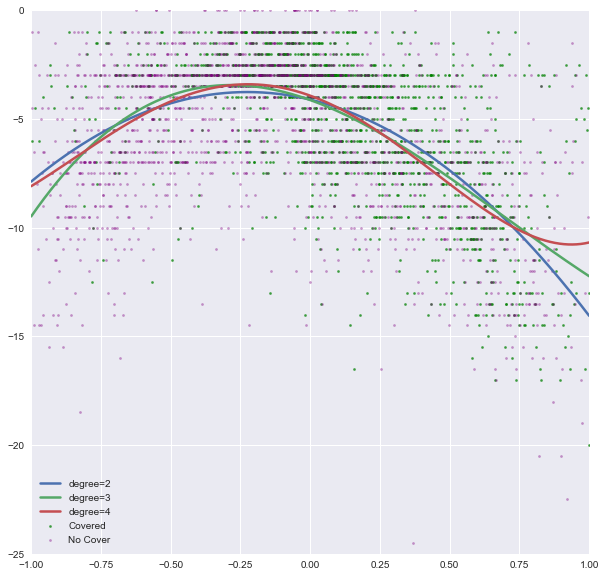

In [130]:
poly_regression(reg_df.exp_win_difference, reg_df.spread_favorite, [2,3,4],-1,1, -25, 0,-1,1)

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     897.4
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          2.22e-177
Time:                        17:38:49   Log-Likelihood:                -9776.1
No. Observations:                3841   AIC:                         1.956e+04
Df Residuals:                    3839   BIC:                         1.957e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.1326      0

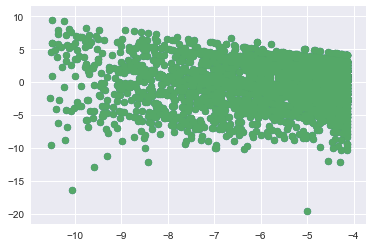

In [131]:
regression_evaluation(reg_df.spread_favorite, (reg_df.exp_win_difference**2))

# Regression of Spread with All Variables

### Variables: Last 4 Difference, Expected Win Difference, Home Favorite

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     204.2
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          7.19e-123
Time:                        17:38:49   Log-Likelihood:                -9895.1
No. Observations:                3841   AIC:                         1.980e+04
Df Residuals:                    3837   BIC:                         1.982e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4933      0.096    -57.077      0.0

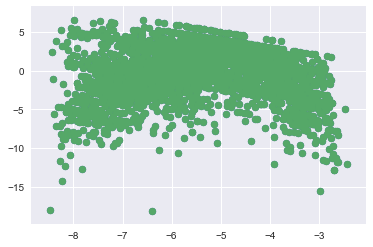

In [132]:
regression_evaluation(reg_df.spread_favorite, reg_df[['last_four_difference', 'exp_win_difference', 'home_favorite']].values)

In [133]:
def test_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    
    split = train_test_split(x, y,test_size = 0.25, random_state = 42)
    print(split[0].features)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [134]:
test_df = reg_df[(reg_df.schedule_week>4)]
test_df[test_df.weather_detail=='DOME']
test_df['dome'] = np.where(test_df['weather_detail']=='DOME', 1, 0)

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [135]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [136]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [150]:
#log_log_regression_evaluation(week5_df.spread_favorite, week5_df[['home_favorite', 'exp_win_difference','last_four_difference']])

In [151]:
#log_log_regression_evaluation(week5_df.over_under_line, week5_df[['weather_temperature', 'weather_wind_mph','weather_humidity', 'total_ppg', 'total_points_against']])

In [152]:
#log_log_regression_evaluation(reg_df.spread_favorite, reg_df.exp_win_difference)

In [153]:
#poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)
#log_log_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],3,4.4,3.2,4.2,0,5)
#log_linear_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],-15,85,3.2,4.2,15,75)#log-linear reg, change logx to x in function

In [154]:
# y = 8.5852+.0298*(week5_df.weather_temperature)-.113*(week5_df.weather_wind_mph)-.0103*(week5_df.weather_humidity)+.4529*(week5_df.total_ppg)+.3294*(week5_df.total_points_against)
# ou_df = week5_df[['over_under_line','over_under_result','point_total']]

# ou_df['prediction']= y
# ou_df['over_under_result'] = np.where(ou_df['over_under_result']=='over', 1, 0)

# ou_df['good_prediction']=np.where((ou_df['prediction']<ou_df['over_under_line']) & (ou_df['over_under_result']==0),1,0)
# ou_df['good_prediction']=np.where((ou_df['prediction']>ou_df['over_under_line']) & (ou_df['over_under_result']==1),1,ou_df['good_prediction'])

In [155]:
#np.sum(ou_df.good_prediction)/len(ou_df)

In [156]:
pd.set_option('display.max_columns', 1000)